In [1]:
# Todo:
# [ ] Convert important text fields (team, position, etc) to numeric values so they can be included in kmeans, pca, etc.
# [ ] Figure out what do with playerSeasons that have multiple teams per record (see Joe Thorton, 2005-2006)
# [ ] Test kmeans based predictions aiming for the light blue segment in the last chart (normalizing numeric values
#   threw off that nice(ish) graph, need to find new success markers)
# [ ] Figure out color duplication issue in cluster graphs
# [ ] Re-examine distributions for outliers to remove. Potentially throwing off min_max scaling?

In [2]:
#Imports
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [3]:
# Make sure plots show
%matplotlib inline

In [4]:
# Global Constants
json_file = '../data/nhl_player_data_2000_2017.json' # Note that this data is for regular season games only
plt.rcParams['figure.figsize'] = [16.0, 10.0] # Make plots visible

In [5]:
# Load Raw JSON and Store Count
with open(json_file) as open_file:
    raw_data = json.load(open_file)
    
playerSeasonCount = raw_data['total']
data = pd.DataFrame(raw_data['data'])

In [6]:
data.describe()

,assists,faceoffWinPctg,gameWinningGoals,gamesPlayed,goals,otGoals,penaltyMinutes,playerId,plusMinus,points,pointsPerGame,ppGoals,ppPoints,seasonId,shGoals,shPoints,shiftsPerGame,shootingPctg,shots,timeOnIcePerGame
count,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000,1.408400e+04,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000,1.408400e+04,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000
mean,12.675447,0.270789,1.189506,48.983811,7.424666,0.149673,34.138455,8.468032e+06,-0.354729,20.100114,0.332874,1.890443,5.478628,2.008452e+07,0.244249,0.504970,19.609634,0.074751,79.987575,887.760996
std,13.050123,0.268656,1.761688,28.649813,8.870714,0.445455,34.808030,6.876435e+03,9.419838,20.765997,0.269224,3.219380,8.362384,4.958215e+04,0.680407,1.054661,5.513041,0.075765,70.670813,295.732570
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,8.444894e+06,-46.000000,0.000000,0.000000,0.000000,0.000000,2.000200e+07,0.000000,0.000000,1.000000,0.000000,0.000000,25.000000
25%,2.000000,0.000000,0.000000,21.000000,1.000000,0.000000,8.000000,8.465026e+06,-5.000000,3.000000,0.133300,0.000000,0.000000,2.003200e+07,0.000000,0.000000,15.912425,0.022900,18.000000,674.440300
50%,9.000000,0.307600,0.000000,57.000000,4.000000,0.000000,26.000000,8.469549e+06,-1.000000,13.000000,0.272700,0.000000,1.000000,2.009201e+07,0.000000,0.000000,20.044100,0.069100,66.000000,894.829850
75%,20.000000,0.489100,2.000000,76.000000,11.000000,0.000000,48.000000,8.473485e+06,4.000000,31.000000,0.489300,3.000000,8.000000,2.013201e+07,0.000000,1.000000,23.643850,0.111100,123.000000,1104.368750
max,96.000000,1.000000,12.000000,85.000000,65.000000,5.000000,354.000000,8.480087e+06,52.000000,125.000000,2.000000,27.000000,61.000000,2.016202e+07,9.000000,11.000000,35.520500,1.000000,528.000000,1768.435800


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feca7353e10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7feca38244e0>]], dtype=object)

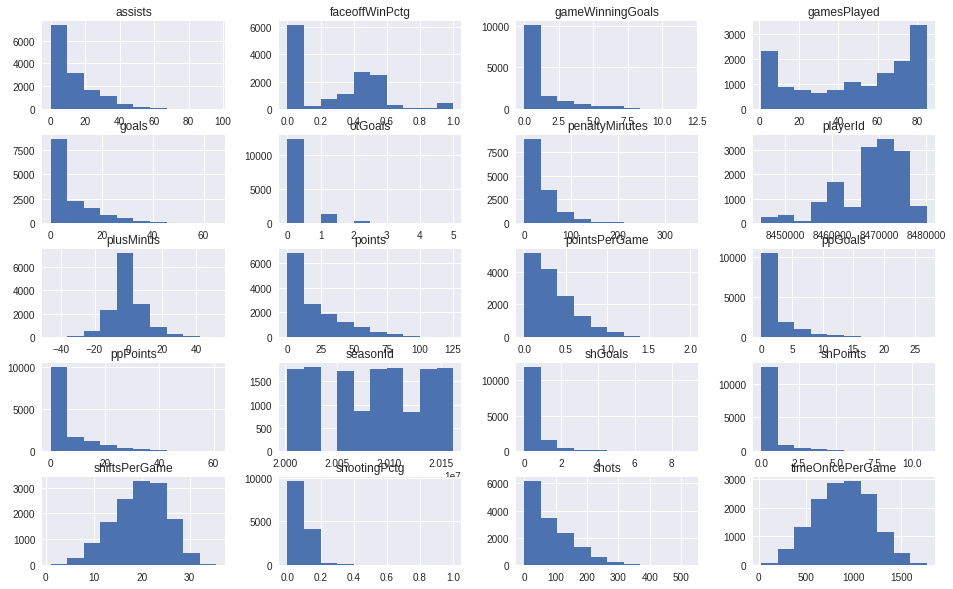

In [7]:
data.hist()

In [8]:
# Removing some likely unwanted fields based on quick look at distribution/relevance to problem
data.drop(['gameWinningGoals', 'faceoffWinPctg', 'ppGoals', 'ppPoints', 'shGoals', 'shPoints'], axis=1, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feca323eb00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fec9e3fa860>]], dtype=object)

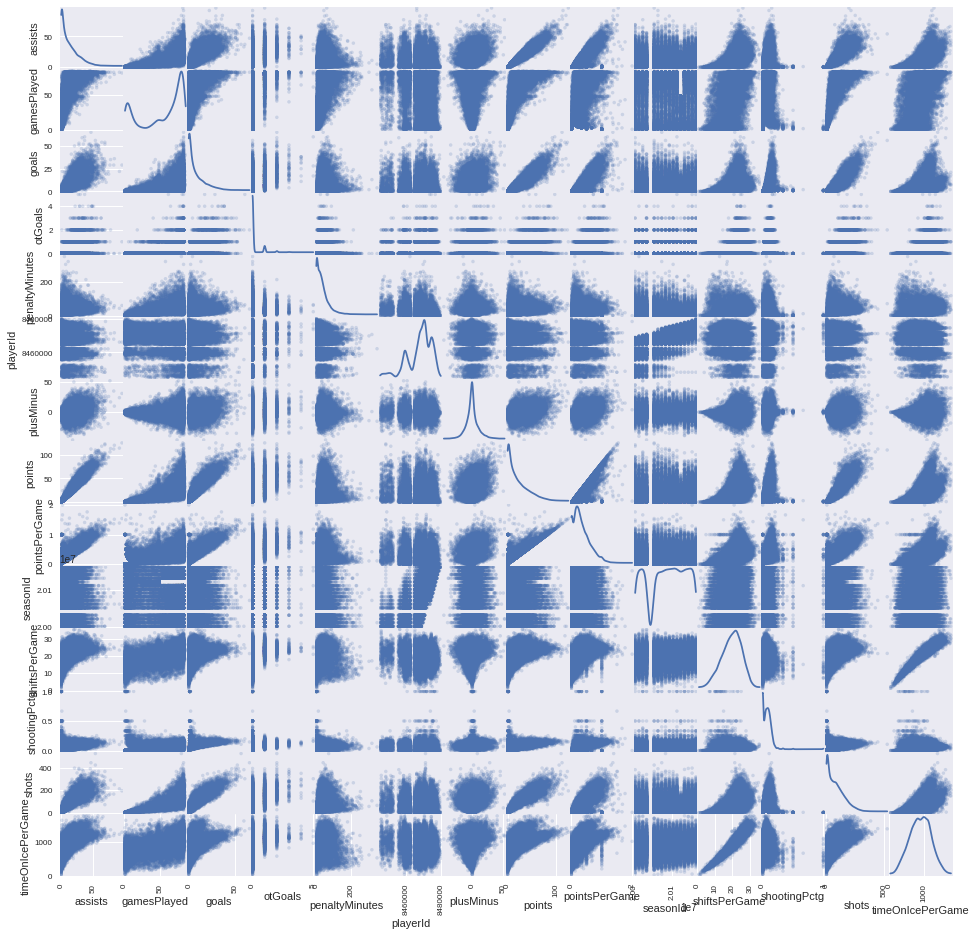

In [9]:
scatter_matrix(data, alpha=0.2, figsize=(16, 16), diagonal='kde')

In [10]:
data.head()

,assists,gamesPlayed,goals,otGoals,penaltyMinutes,playerFirstName,playerId,playerLastName,playerName,playerPositionCode,playerTeamsPlayedFor,plusMinus,points,pointsPerGame,seasonId,shiftsPerGame,shootingPctg,shots,timeOnIcePerGame
0,96,81,29,1,61,Joe,8466138,Thornton,Joe Thornton,C,"BOS, SJS",31,125,1.5432,20052006,26.0000,0.1487,195,1280.1975
1,69,82,54,2,72,Jaromir,8448208,Jagr,Jaromir Jagr,R,NYR,34,123,1.5000,20052006,22.2195,0.1467,368,1324.5000
2,69,81,52,0,42,Jaromir,8448208,Jagr,Jaromir Jagr,R,PIT,19,121,1.4938,20002001,23.4320,0.1640,317,1398.5432
3,84,79,36,0,60,Sidney,8471675,Crosby,Sidney Crosby,C,PIT,10,120,1.5189,20062007,24.4303,0.1440,250,1245.5443
4,64,82,54,2,30,Joe,8451101,Sakic,Joe Sakic,C,COL,45,118,1.4390,20002001,31.7195,0.1626,332,1381.0731


count    14084.000000
mean       887.760996
std        295.732570
min         25.000000
25%        674.440300
50%        894.829850
75%       1104.368750
max       1768.435800
Name: timeOnIcePerGame, dtype: float64

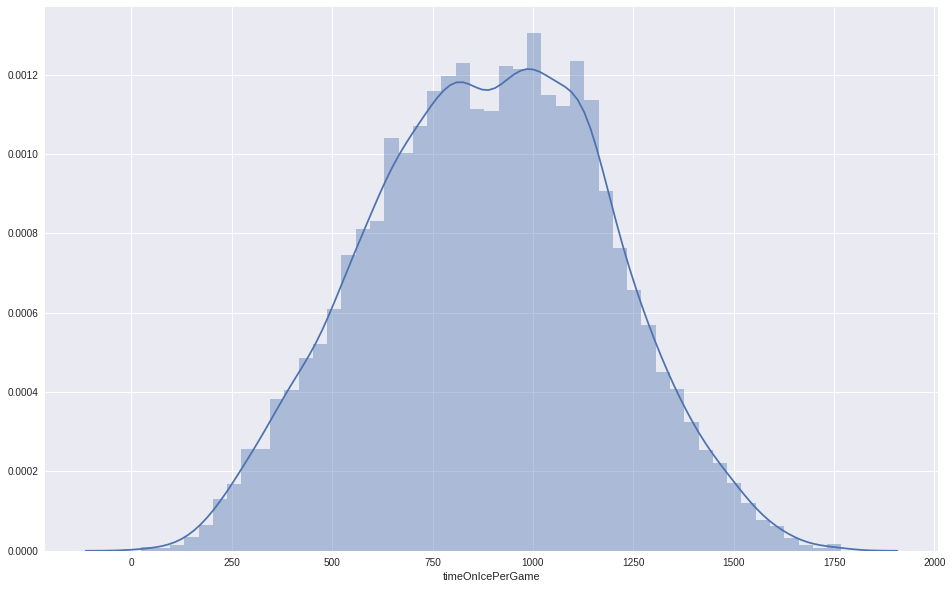

In [11]:
# Note that timeOnIcePerGame is in seconds!
sns.distplot(data['timeOnIcePerGame'])
data['timeOnIcePerGame'].describe()

count    14084.000000
mean        48.983811
std         28.649813
min          1.000000
25%         21.000000
50%         57.000000
75%         76.000000
max         85.000000
Name: gamesPlayed, dtype: float64

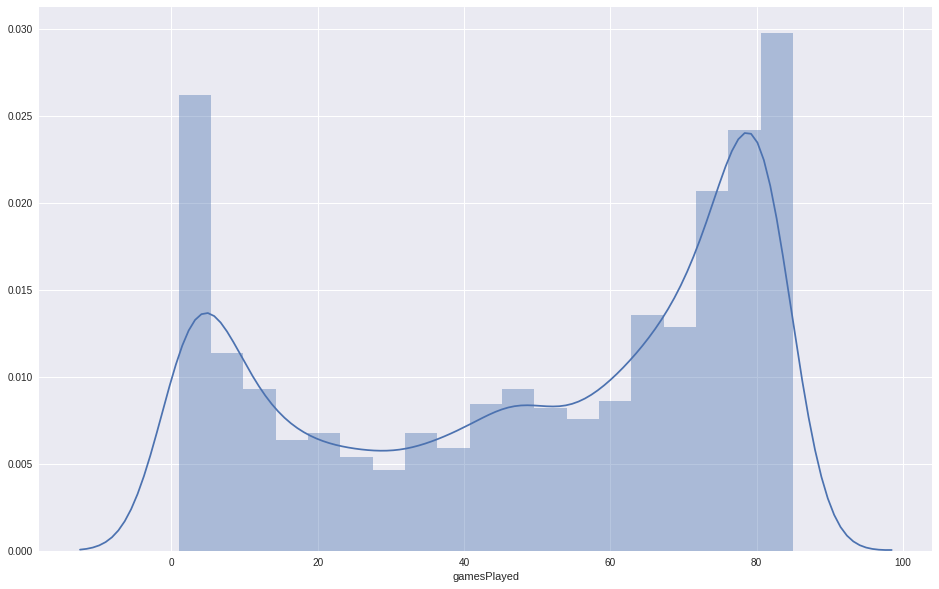

In [12]:
sns.distplot(data['gamesPlayed'])
data['gamesPlayed'].describe()

count    14084.000000
mean        19.609634
std          5.513041
min          1.000000
25%         15.912425
50%         20.044100
75%         23.643850
max         35.520500
Name: shiftsPerGame, dtype: float64

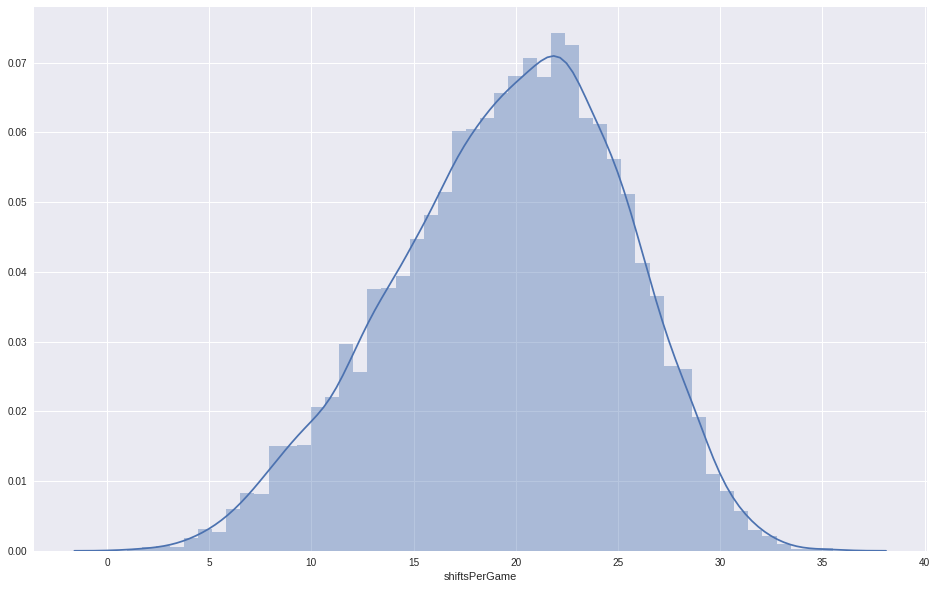

In [13]:
sns.distplot(data['shiftsPerGame'])
data['shiftsPerGame'].describe()

count    14084.000000
mean        -0.354729
std          9.419838
min        -46.000000
25%         -5.000000
50%         -1.000000
75%          4.000000
max         52.000000
Name: plusMinus, dtype: float64

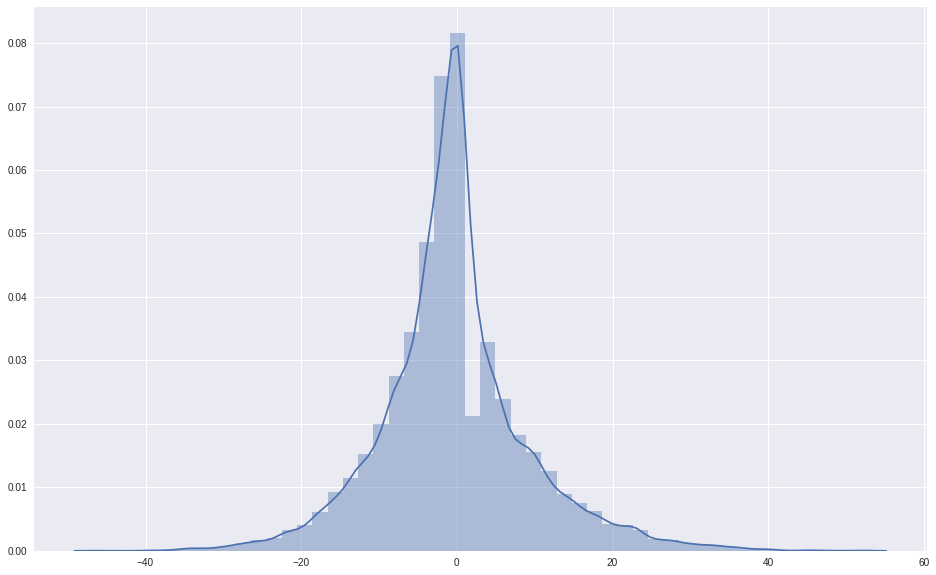

In [14]:
sns.distplot([data['plusMinus']])
data['plusMinus'].describe()

In [15]:
# Unneeded now that we're normalizing below

# convert timeOnIcePerGame from seconds to minutes
# worried about disproportionate effects of timeOnIcePerGame on clustering due to larger scale
# data['timeOnIcePerGame'] = data['timeOnIcePerGame'].apply(lambda x: int(x)/60)

In [16]:
# Time to start screwing around! Filter down to numeric columns and convert dataframe to nparray for scikitlearnin'
kmeans_df = data.loc[:, ['plusMinus', 'shiftsPerGame', 'gamesPlayed', 'timeOnIcePerGame']]
data_arr = kmeans_df.as_matrix()

In [17]:
# Normalize numeric fields to get rid of scale biases
min_max_scaler = preprocessing.MinMaxScaler()
data_arr = min_max_scaler.fit_transform(data_arr)

In [18]:
kmeans = KMeans().fit(data_arr)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [19]:
print(min(labels))
print(max(labels))
colorized_labels = list(map(lambda x: 'C'+str(x), labels))

0
7


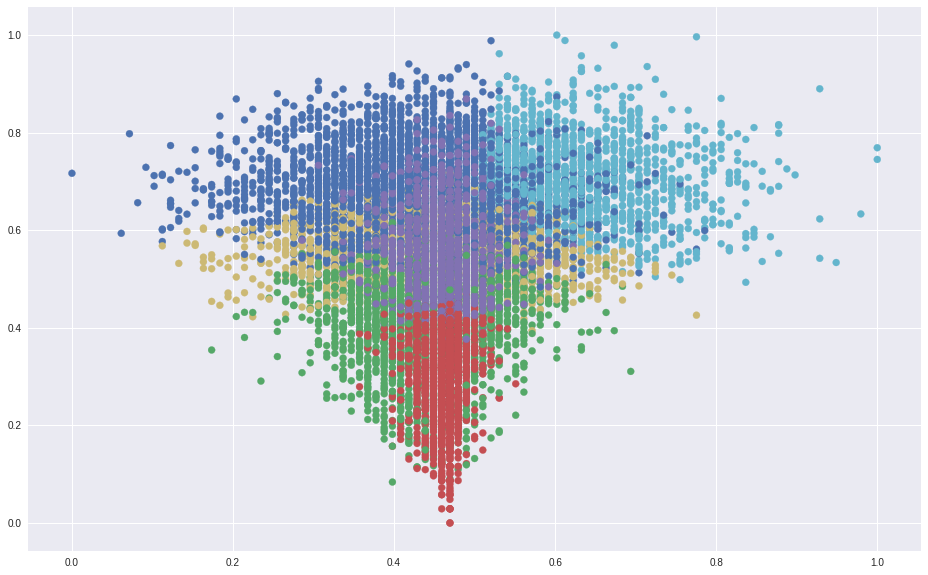

In [20]:
# plusMinus vs shiftsPerGame
plt.figure(1)
plt.clf()
plt.scatter(data_arr[:, 0], data_arr[:, 1], c=colorized_labels)

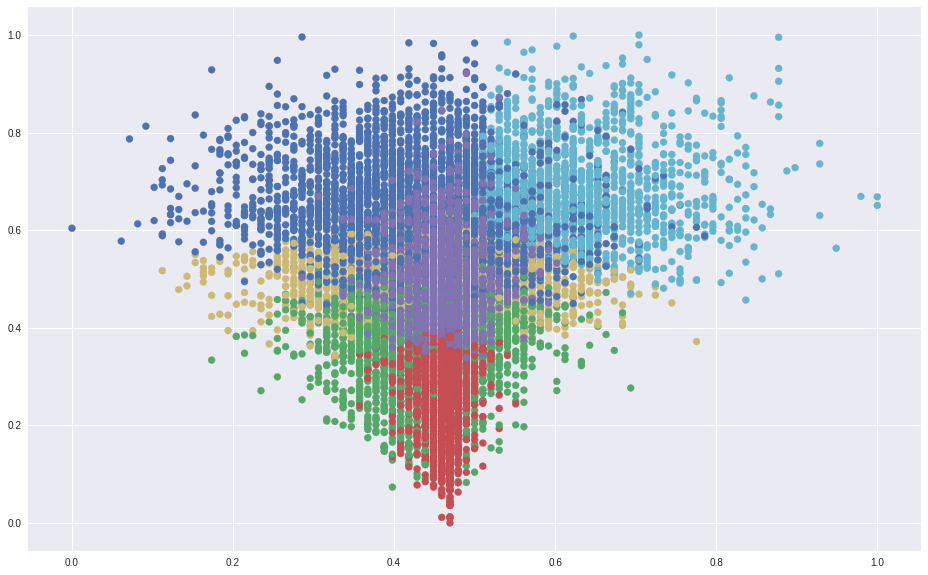

In [21]:
# plusMinus vs timeOnIcePerGame
plt.figure(2)
plt.clf()
plt.scatter(data_arr[:, 0], data_arr[:, 3], c=colorized_labels)

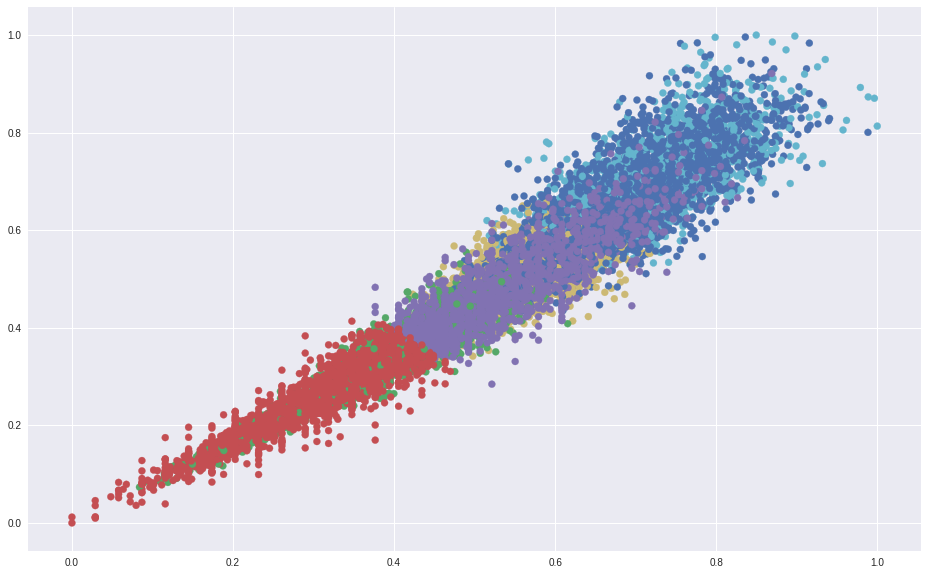

In [22]:
# shiftsPerGame vs timeOnIcePerGame
plt.figure(3)
plt.clf()
plt.scatter(data_arr[:, 1], data_arr[:, 3], c=colorized_labels)

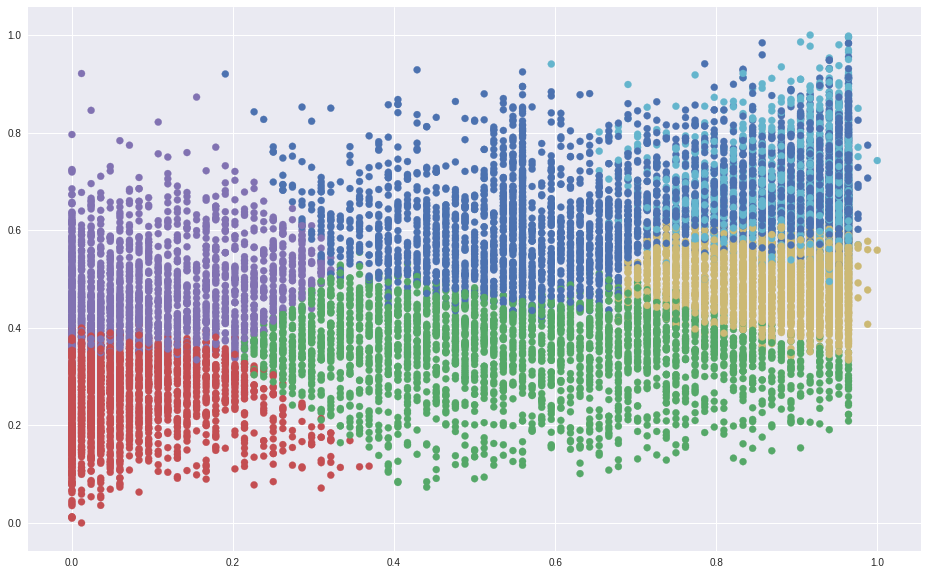

In [23]:
# gamesPlayed vs timeOnIcePerGame
plt.figure(4)
plt.clf()
plt.scatter(data_arr[:, 2], data_arr[:, 3], c=colorized_labels)

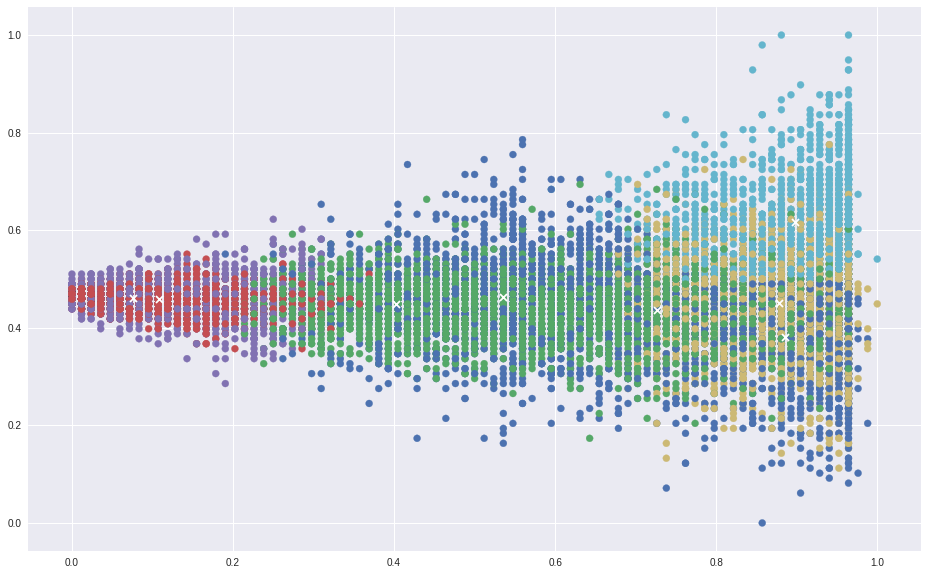

In [24]:
# gamesPlayed vs plusMinus
plt.figure(5)
plt.clf()
plt.scatter(data_arr[:, 2], data_arr[:, 0], c=colorized_labels)
plt.scatter(centroids[:, 2], centroids[:, 0], c='w', marker='x')

In [25]:
# Initial attempt at defining isSuccessfulSeason
def isSuccessfulSeason(row):
    val = 0
    if row['gamesPlayed'] >= 60 and row['plusMinus'] >=5:
        val = 1
    return val

In [26]:
data['isSuccessfulSeason'] = data.apply(lambda x: isSuccessfulSeason(x), axis=1)

In [27]:
data['isSuccessfulSeason'].describe()

count    14084.000000
mean         0.167140
std          0.373114
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: isSuccessfulSeason, dtype: float64

In [28]:
# Write attempt at labeled data to csv
write_path = '../data/labeled_player_seasons.csv'
data.to_csv(write_path)